# Loopy: Dealing with Intermediate Results

## Setup code

In [1]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clmath
import pyopencl.clrandom
import loopy as lp

from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2

In [2]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7f79b0a7e6e8>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x1af0e48>


Choice [0]: 


Set the environment variable PYOPENCL_CTX='' to avoid being asked again.


In [3]:
grid = np.linspace(0, 2*np.pi, 2048, endpoint=False)
h = grid[1] - grid[0]
u = cl.clmath.sin(cl.array.to_device(queue, grid))

## Two kernels: Finite Differences and a Flux

We will implement computing the ODE right-hand side for Burgers' equation:
$$
\frac{\partial u}{\partial t} + \frac{\partial }{\partial x} \left( \frac{u^2}2 \right) = 0,
$$

Now, it is likely that the code fore the derivative is initially separate from the code for the flux function $f(u):=u^2/2$.

For simplicity, we will use central finite differences to build a kernel `fin_diff_knl` to take the derivative:

In [4]:
fin_diff_knl = lp.make_kernel(
    "{[i]: 1<=i<=n}",
    "out[i] = -(f[i+1] - f[i-1])/(2*h)",
    [lp.GlobalArg("out", shape="2+n"), ...])
print(fin_diff_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : 0 < i <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
---------------------------------------------------------------------------
INSTRUCTIONS:
for i
  out[i] = ((-1)*(f[i + 1] + (-1)*f[i + -1])) / (2*h)  {id=insn}
end i
---------------------------------------------------------------------------


------------
Next, make the flux kernel as `flux_knl`.
* Use `j` as the loop variable.
* Make sure to declare `f` and `u` to be the right size.

In [5]:
flux_knl = lp.make_kernel(
    "{[j]: 1<=j<=n}",
    "f[j] = u[j]**2/2",
    [
    lp.GlobalArg("f", shape="2+n"),
    lp.GlobalArg("u", shape="2+n"),
    ])
print(flux_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [j] : 0 < j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
for j
  f[j] = u[j]**2 / 2  {id=insn}
end j
---------------------------------------------------------------------------


## Fuse the Kernels

Next, fuse the two kernels together as `fused_knl`, using `lp.fuse_kernels([knl_a, knl_b])`:

In [6]:
#clear
fused_knl = lp.fuse_kernels([fin_diff_knl, flux_knl])

print(fused_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : 0 < i <= n }
[n] -> { [j] : 0 < j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
for i
  out[i] = ((-1)*(f[i + 1] + (-1)*f[i + -1])) / (2*h)  {id=insn}
end i
for j
  f[j] = u[j]**2 / 2  {id=insn_0}
end j
----------------

Let's take a look at the generated code:

In [7]:
fused_knl = lp.set_options(fused_knl, write_cl=True)
evt, _ = fused_knl(queue, u=u, h=np.float32(1e-1))

/home/andreas/src/loopy/loopy/kernel/creation.py:1803: LoopyWarning: in kernel loopy_kernel_and_loopy_kernel: The single-writer dependency heuristic added dependencies on instruction ID(s) 'insn_0' to instruction ID 'insn' after kernel creation is complete. This is deprecated and may stop working in the future. To fix this, ensure that instruction dependencies are added/resolved as soon as possible, ideally at kernel creation time. (add 'single_writer_after_creation' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(kernel, "single_writer_after_creation",


#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel_and_loopy_kernel(__global double *__restrict__ out, __global double *__restrict__ f, float const h, int const n, __global double const *__restrict__ u)
{
  for (int j = 1; j <= n; ++j)
    f[j] = (u[j] * u[j]) / 2.0;
  for (int i = 1; i <= n; ++i)
    out[i] = (-1.0 * (f[1 + i] + -1.0 * f[-1 + i])) / (2.0 * h);
}



Next, eliminate the separate loop to compute `f`:

In [8]:
fused_knl = lp.assignment_to_subst(fused_knl, "f")
print(fused_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : 0 < i <= n }
[n] -> { [] : n > 0 }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
---------------------------------------------------------------------------
SUBSTITUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------------------
INSTRUCTIONS:
for i
  out[i] = ((-1)*(f_subst(i + 1) + (-1)*f_subst(i + -1))) / (2*h)  {id=insn}
end i
----------------------

Again, let's take a look at the generated code:

In [9]:
fused_knl = lp.set_options(fused_knl, write_cl=True)
evt, _ = fused_knl(queue, u=u, h=np.float32(1e-1))

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel_and_loopy_kernel(__global double *__restrict__ out, float const h, int const n, __global double const *__restrict__ u)
{
  for (int i = 1; i <= n; ++i)
    out[i] = (-1.0 * ((u[1 + i] * u[1 + i]) / 2.0 + -1.0 * ((u[-1 + i] * u[-1 + i]) / 2.0))) / (2.0 * h);
}



## Transform the kernel for execution

For easier transformation, renumber the loop to start at 0, using `affine_map_inames(kernel, old_inames, new_inames, equations)`:

In [10]:
fused0_knl = lp.affine_map_inames(fused_knl, "i", "inew", "inew+1=i")

print(fused0_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [inew] : 0 <= inew < n }
[n] -> { [] : n > 0 }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
inew: None
---------------------------------------------------------------------------
SUBSTITUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------------------
INSTRUCTIONS:
for inew
  out[1 + inew] = ((-1)*(f_subst(1 + 1 + inew) + (-1)*f_subst(-1 + 1 + inew))) / (2*h)  {id=i

Now, map the kernel to OpenCL axes:

In [11]:
gpu_knl = lp.split_iname(fused0_knl, "inew", 128, outer_tag="g.0", inner_tag="l.0")
print(gpu_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [inew_outer, inew_inner] : inew_inner >= 0 and -128inew_outer <= inew_inner <= 127 and inew_inner < n - 128inew_outer }
[n] -> { [] : n > 0 }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
inew_inner: l.0
inew_outer: g.0
---------------------------------------------------------------------------
SUBSTITUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------------------


Finally, precompute the fluxes locally in each workgroup:

In [16]:
precomp_knl = lp.precompute(gpu_knl, "f_subst", "inew_inner", fetch_bounding_box=True, default_tag="l.auto")
print(precomp_knl)
precomp_knl = lp.tag_inames(precomp_knl, {"j_outer": "unr"})
precomp_knl = lp.set_options(precomp_knl, return_dict=True)
evt, _ = precomp_knl(queue, u=u, h=h)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
out: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n), dim_tags: (N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [inew_outer, inew_inner, j_outer, j_inner] : inew_outer >= 0 and 0 <= inew_inner <= 127 and inew_inner < n - 128inew_outer and j_inner >= 0 and -128j_outer <= j_inner <= 129 - 128j_outer and j_inner <= 127 and j_inner <= 1 + n - 128inew_outer - 128j_outer }
[n] -> { [] : n > 0 }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
inew_inner: l.0
inew_outer: g.0
j_inner: l.0
j_outer: None
---------------------------------

## Run the PDE

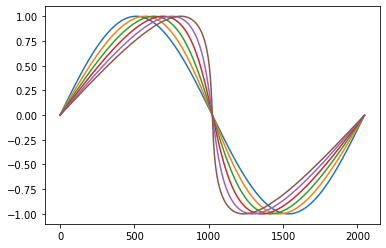

In [17]:
import matplotlib.pyplot as pt

# Forward Euler on a hyperbolic problem: terrible idea. Oh well.

dt = 0.2*h
u = cl.clmath.sin(cl.array.to_device(queue, grid))
for i in range(1800):
    _, result_dict = precomp_knl(queue, u=u, h=h)
    out = result_dict["out"]
    out[0] = out[-1] = 0
    u = u + dt*out
    
    if i % 300 == 0:
        pt.plot(u.get())